# Reproduction of spontaneous dynamics from Goldman et al. 2020

Here, the spontaneous activity of the mean-field AdEx model (`ZerlautAdaptationSecondOrder`) is shown in two distinct regimes: asynchronous fluctuations and synchronous slow waves. 

Goldman, J. S., Kusch, L., Yalçinkaya, B. H., Depannemaecker, D., Nghiem, T.-A. E., Jirsa, V., & Destexhe, A. (2021). A comprehensive neural simulation of slow-wave sleep and highly responsive wakefulness dynamics. In [bioRxiv](https://doi.org/10.1101/2021.08.31.458365) (p. 2021.08.31.458365). 

In [1]:
%matplotlib inline

In [6]:
import matplotlib.pylab as plt
import numpy as np

from tvb.simulator.lab import *
from utils import load_tvb_model_toml

## Asynchronous regime

Without adaptation (`b_e = 0`), the model exhibits asynchronous fluctuations resembling the brain dynamics in wakefulness.

In [11]:
adex = load_tvb_model_toml(models.ZerlautAdaptationSecondOrder,'cfgs/goldman2020.toml')

In [13]:
adex

Next, we configure the default connectome.

In [14]:
conn = connectivity.Connectivity.from_file()
conn.weights = conn.weights/(np.sum(conn.weights,axis=0)+1e-12)
conn.speed = np.r_[4.0]

WARNING  File 'hemispheres' not found in ZIP.


In the visualizations below, we discard the initial transient of 2 seconds.

In [15]:
transient = 2000.0

Putting it all together. Note, that the driving noise enters into the last state variable representing the Ohrnstein-Uhlenbeck process for each node. 

In [16]:
sim = simulator.Simulator(
    model=adex,
    connectivity=conn,
    conduction_speed=conn.speed.item(), 
    coupling=coupling.Linear(a=np.r_[0.3]),
    integrator=integrators.HeunStochastic(
        noise=noise.Additive(nsig=np.r_[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]),
        dt = 0.1,
    ),
    monitors=[monitors.TemporalAverage(period=1.0)],
    #stimulus=stim,
).configure()

In [17]:
(out_t, out_d),  = sim.run(simulation_length=8000 + transient)

In [19]:
t_trans = int(transient)

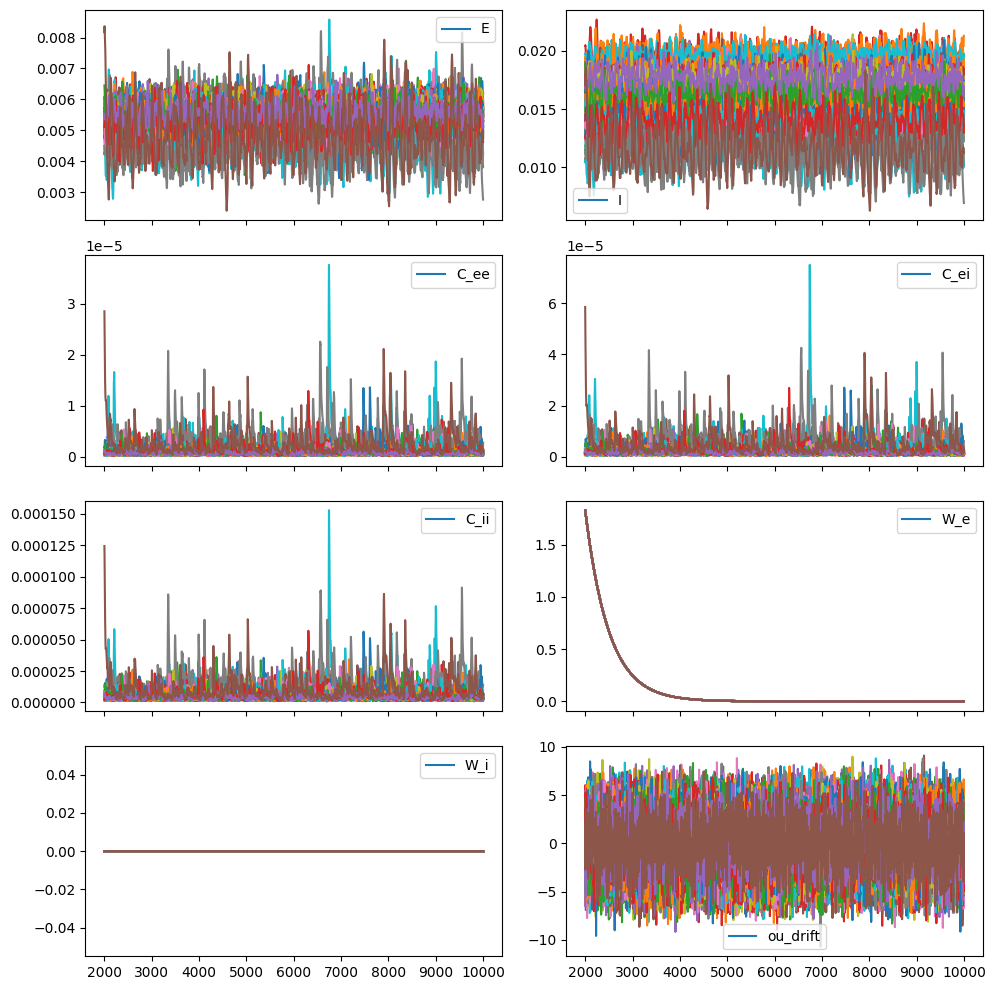

In [20]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,10), sharex=True)
for i,(var, ax) in enumerate(zip(adex.state_variables, axs.flatten())):
    ax.plot(out_t[t_trans:], out_d[t_trans:,i,:,0])
    ax.legend(labels=[var])
fig.tight_layout()

## Slow wave regime

With adaptation (`b_e = 60`), the model exhibits synchronous slow wave oscillations resembling the brain dynamics in sleep. All other parameters are identical to the asynchronous regime.

In [22]:
sim = simulator.Simulator(
    model=adex,
    connectivity=conn,
    conduction_speed=conn.speed.item(), 
    coupling=coupling.Linear(a=np.r_[0.3]),
    integrator=integrators.HeunStochastic(
        noise=noise.Additive(nsig=np.r_[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]),
        dt = 0.1,
    ),
    monitors=[monitors.TemporalAverage(period=1.0)],
    #stimulus=stim,
).configure()

sim.model.b_e = np.r_[60.]

In [23]:
(out_t, out_d),  = sim.run(simulation_length=8000 + transient)

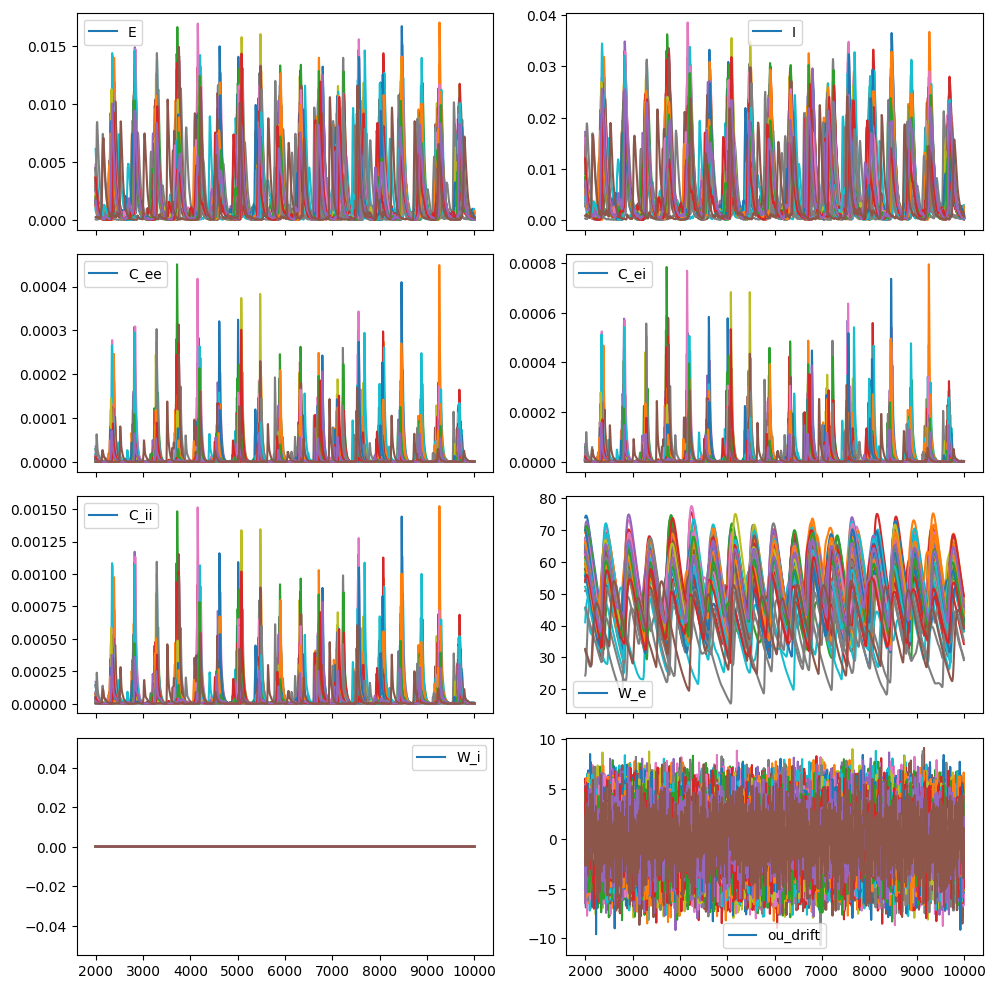

In [26]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,10), sharex=True)
for i,(var, ax) in enumerate(zip(adex.state_variables, axs.flatten())):
    ax.plot(out_t[t_trans:], out_d[t_trans:,i,:,0])
    ax.legend(labels=[var])
fig.tight_layout()